In [1]:
import numpy as np
import itertools
import json

from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve, _SigmoidCalibration, _sigmoid_calibration
from ampligraph.evaluation import evaluate_performance, mr_score, mrr_score, hits_at_n_score, generate_corruptions_for_eval
from sklearn.metrics import brier_score_loss, log_loss
from scipy.special import expit

from ampligraph.datasets import load_wn18rr
from ampligraph.latent_features.models import TransE, ComplEx

In [40]:
from generate_corruptions import generate_corruptions, calibration_loss, pos_iso

In [3]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
X = load_wn18rr()

In [36]:
import types
from functools import partial
import tensorflow as tf
from sklearn.utils import check_random_state
from tqdm import tqdm
from ampligraph.datasets import AmpligraphDatasetAdapter, NumpyDatasetAdapter
from ampligraph.evaluation import generate_corruptions_for_fit, to_idx, generate_corruptions_for_eval, \
    hits_at_n_score, mrr_score


def generate_corruptions_triples(self, X_pos, batches_count, epochs):
    try:
        tf.reset_default_graph()
        self.rnd = check_random_state(self.seed)
        tf.random.set_random_seed(self.seed)

        self._load_model_from_trained_params()

        dataset_handle = NumpyDatasetAdapter()
        dataset_handle.use_mappings(self.rel_to_idx, self.ent_to_idx)

        dataset_handle.set_data(X_pos, "pos")

        batch_size_pos = int(np.ceil(dataset_handle.get_size("pos") / batches_count))

        gen_fn = partial(dataset_handle.get_next_batch, batches_count=batches_count, dataset_type="pos")
        dataset = tf.data.Dataset.from_generator(gen_fn,
                                                 output_types=tf.int32,
                                                 output_shapes=(None, 3))
        dataset = dataset.repeat().prefetch(1)
        dataset_iter = tf.data.make_one_shot_iterator(dataset)

        x_pos_tf = dataset_iter.get_next()

        e_s, e_p, e_o = self._lookup_embeddings(x_pos_tf)
        scores_pos = self._fn(e_s, e_p, e_o)

        x_neg_tf = generate_corruptions_for_fit(x_pos_tf,
                                                entities_list=None,
                                                eta=1,
                                                corrupt_side='s+o',
                                                entities_size=0,
                                                rnd=self.seed)

        epoch_iterator_with_progress = tqdm(range(1, epochs + 1), disable=(not self.verbose), unit='epoch')

        scores_list = []
        with tf.Session(config=self.tf_config) as sess:
            sess.run(tf.global_variables_initializer())
            for _ in epoch_iterator_with_progress:
                losses = []
                for batch in range(batches_count):
                    scores_list.append(sess.run(x_neg_tf))

        dataset_handle.cleanup()
        return np.concatenate(scores_list)
    
    except Exception as e:
        print(e)
        dataset_handle.cleanup()

In [24]:
def pos_iso(cal_model, pos_scores, neg_scores, positive_base_rate):
    weigths_pos = len(neg_scores) / len(pos_scores)
    weights_neg = (1.0 - positive_base_rate) / positive_base_rate
    weights = np.concatenate((np.full(pos_scores.shape, weigths_pos),
                              np.full(neg_scores.shape, weights_neg))).astype(float)
    target =  np.concatenate((np.ones(pos_scores.shape), np.zeros(neg_scores.shape))).astype(float)
    x = np.concatenate((pos_scores, neg_scores)).astype(float)
    
    cal_model.fit(x, target, sample_weight=weights)
    return cal_model

In [ ]:
model = ComplEx(batches_count=10, seed=0, epochs=4000, k=200, eta=20,
                # Use adam optimizer with learning rate 1e-3
                optimizer='adam', optimizer_params={'lr':0.0005},
                # Use pairwise loss with margin 0.5
                loss='multiclass_nll',
                # Use L2 regularizer with regularizer weight 1e-5
                regularizer='LP', regularizer_params={'p':3, 'lambda':0.05}, 
                # Enable stdout messages (set to false if you don't want to display)
                verbose=True)

filter_triples = np.concatenate((X['train'], X['valid'], X['test']))

# Fit the model on training and validation set
model.fit(X['train'], 
          early_stopping = True,
          early_stopping_params = \
                  {
                      'x_valid': X['valid'],       # validation set
                      'criteria':'mrr',         # Uses hits10 criteria for early stopping
                      'burn_in': 100,              # early stopping kicks in after 100 epochs
                      'check_interval':100,         # validates every 20th epoch
                      'stop_interval':2,           # stops if 5 successive validation checks are bad.
                      'x_filter': filter_triples,          # Use filter for filtering out positives 
                      'corruption_entities':'all', # corrupt using all entities
                      'corrupt_side':'s+o'         # corrupt subject and object (but not at once)
                  }
          )



In [7]:
ranks = evaluate_performance(X['test'], 
                             model=model, 
                             filter_triples=filter_triples,
                             use_default_protocol=True, 
                             verbose=False)


100%|██████████| 2924/2924 [00:23<00:00, 124.67it/s]

In [8]:
mrr_score(ranks),  hits_at_n_score(ranks, n=10), mr_score(ranks)

(0.5059065017035501, 0.5827633378932968, 4110.8835499316)

In [37]:
model.generate_corruptions_triples = types.MethodType(generate_corruptions_triples, model)
fake_negatives = model.generate_corruptions_triples(X['test'], batches_count=10, epochs=1000)


100%|██████████| 1000/1000 [00:17<00:00, 57.68epoch/s]

In [38]:
idx_to_ent = {v: k for k, v in model.ent_to_idx.items()} 
idx_to_rel = {v: k for k, v in model.rel_to_idx.items()} 

In [ ]:
results = []

for pbr in np.linspace(0.05, 0.95, 19):
    
    fake_idx = np.random.randint(len(fake_negatives), size=int(len(X['test'])/pbr-len(X['test'])))
    fake_test = fake_negatives[fake_idx, :]

    s = np.vectorize(idx_to_ent.get)(fake_test[:, 0])
    p = np.vectorize(idx_to_rel.get)(fake_test[:, 1])
    o = np.vectorize(idx_to_ent.get)(fake_test[:, 2])

    fake_test = np.vstack((s, p, o)).T
    X_test = np.vstack((X['test'], fake_test))
    X_test_labels = np.concatenate((np.ones(len(X['test'])), np.zeros(len(fake_idx))))
    
    scores = model.predict(X_test)

    model.calibrate(X['valid'], batches_count=10, epochs=1000, positive_base_rate=pbr)
    print("pos", model.calibration_parameters)
    probas1 = model.predict_proba(X_test)

    model.generate_corruptions = types.MethodType(generate_corruptions, model)
    corruptions = model.generate_corruptions(X['valid'], batches_count=10, epochs=1000)
    val_pos_scores = np.squeeze(model.predict(X['valid']))
    iso_pos = pos_iso(IsotonicRegression(out_of_bounds='clip'), val_pos_scores, corruptions, positive_base_rate=pbr)
    probas4 = iso_pos.predict(np.squeeze(scores).astype(float))

    sc_pos = pos_iso(_SigmoidCalibration(), val_pos_scores, corruptions, positive_base_rate=pbr)
    print("pos sc", sc_pos.a_, sc_pos.b_)
    probas5 = sc_pos.predict(np.squeeze(scores).astype(float))

    results.append({
        'pbr': pbr,
        'brier_score_baseline': brier_score_loss(X_test_labels, np.array([pbr]*len(X_test_labels))),
        'log_loss_baseline': log_loss(X_test_labels, np.array([pbr]*len(X_test_labels)), eps=1e-7),
        'brier_score_scores': brier_score_loss(X_test_labels, expit(scores)),
        'log_loss_scores': log_loss(X_test_labels, expit(scores), eps=1e-7),
        'brier_score_probas_pos': brier_score_loss(X_test_labels, probas1),
        'log_loss_probas_pos': log_loss(X_test_labels, probas1, eps=1e-7),
        'brier_score_probas_pos_iso': brier_score_loss(X_test_labels, probas4),
        'log_loss_probas_pos_iso': log_loss(X_test_labels, probas4, eps=1e-7),
        'brier_score_probas_pos_sc': brier_score_loss(X_test_labels, probas5),
        'log_loss_probas_pos_sc': log_loss(X_test_labels, probas5, eps=1e-7),
        'ece_scores': calibration_loss(X_test_labels, expit(scores)),
        'ece_probas_pos': calibration_loss(X_test_labels, probas1),
        'ece_probas_pos_iso': calibration_loss(X_test_labels, probas4),
        'ece_probas_pos_sc': calibration_loss(X_test_labels, probas5),
        'metrics_mrr': mrr_score(ranks), 
        'metrics_hits@10': hits_at_n_score(ranks, n=10),
        'metrics_mr': mr_score(ranks)
    })
        
    print(json.dumps(results[-1], indent=2))

In [45]:
import pandas as pd

In [46]:
def highlight_min(s):
    is_min = s == s.min()
    return ['font-weight: bold' if v else '' for v in is_min]

In [52]:
df = pd.DataFrame(results).set_index(['pbr'])
df.index = [np.round(i, 2) for i in df.index]
df.to_csv("main_results_wn18rr.csv", index=False)

In [48]:
bs = df[(c for c in df.columns if c.startswith('brier'))]
bs.columns = [c[len("brier_score_"):] for c in bs.columns]
bs.style.apply(highlight_min, axis=1)

,baseline,probas_pos,probas_pos_iso,probas_pos_sc,scores
0.05,0.0475,0.0204772,0.0202608,0.0206498,0.256914
0.1,0.09,0.0367275,0.0362905,0.0363935,0.245649
0.15,0.127502,0.0508174,0.0503519,0.0504945,0.236106
0.2,0.16,0.064252,0.0636569,0.0636655,0.227645
0.25,0.1875,0.0748429,0.0742923,0.0745087,0.216115
0.3,0.210008,0.0847101,0.0842689,0.0842435,0.205406
0.35,0.227504,0.0949277,0.0941582,0.09438,0.196611
0.4,0.24,0.103458,0.102752,0.102993,0.186587
0.45,0.247505,0.111056,0.110261,0.110384,0.177673
0.5,0.25,0.114915,0.113928,0.114623,0.165151


Text(0.5, 1.0, 'WN18RR: Synthetic calibration')

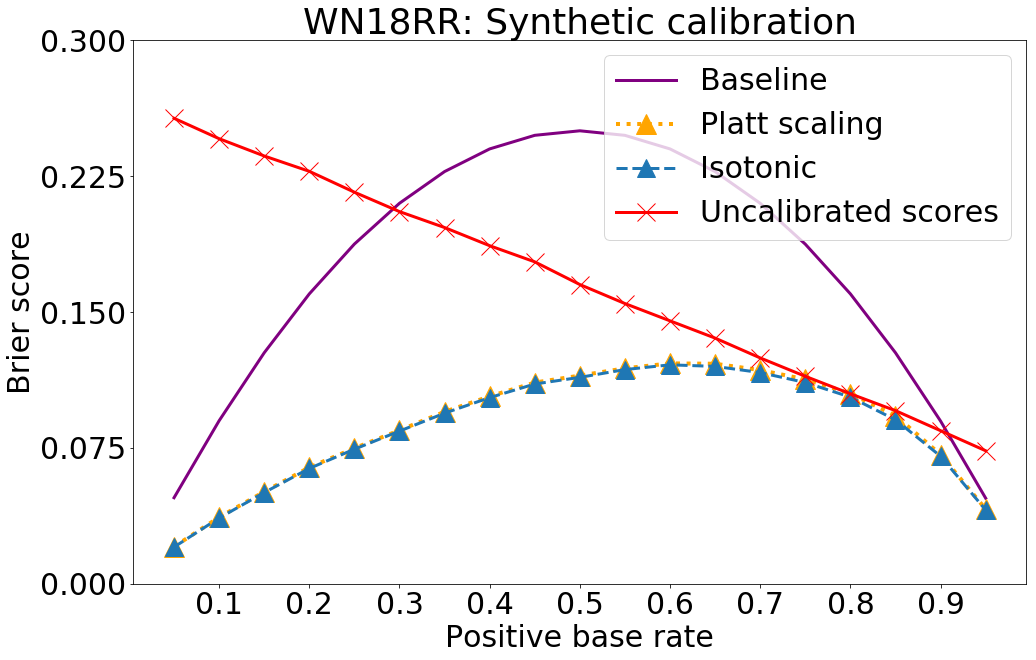

In [75]:
plt.figure(figsize=(16, 10))
plt.rcParams.update({'font.size': 30, 'axes.titlesize': 36})
plt.plot(bs.index, bs.baseline, "-", lw=3, label="Baseline",
         fillstyle='full', color='purple', markersize=18)
plt.plot(bs.index, bs.probas_pos, "^:",lw=4, label="Platt scaling",  
         fillstyle='full', color='orange', markersize=20)
plt.plot(bs.index, bs.probas_pos_iso, "^--",  lw=3, label="Isotonic", 
         fillstyle='full', color='tab:blue', markersize=18)
plt.plot(bs.index, bs.scores, "x-",lw=3,  
         fillstyle='full', color='r', markersize=18,
         label="Uncalibrated scores")

plt.xlabel("Positive base rate")
plt.ylabel("Brier score")
plt.legend()
plt.xticks(np.linspace(0.1, 0.9, 9))
plt.yticks(np.linspace(0, 0.3, 5))
plt.title("WN18RR: Synthetic calibration")

In [50]:
ll = df[(c for c in df.columns if c.startswith('log_loss'))]
ll.columns = [c[len("log_loss_"):] for c in ll.columns]
ll.style.apply(highlight_min, axis=1)

,baseline,probas_pos,probas_pos_iso,probas_pos_sc,scores
0.05,0.198515,0.0996867,0.0931016,0.0955278,0.713062
0.1,0.325083,0.160768,0.152259,0.154384,0.68418
0.15,0.422714,0.211039,0.199617,0.203668,0.65985
0.2,0.500402,0.251014,0.240322,0.243013,0.636024
0.25,0.562335,0.278717,0.270474,0.272438,0.604209
0.3,0.610882,0.300126,0.295308,0.295751,0.57416
0.35,0.647454,0.327162,0.320584,0.321644,0.55088
0.4,0.673012,0.353766,0.342317,0.346742,0.528683
0.45,0.68815,0.366135,0.357217,0.359751,0.502964
0.5,0.693147,0.370178,0.362829,0.365125,0.470326


Text(0.5, 1.0, 'WN18RR: Synthetic calibration')

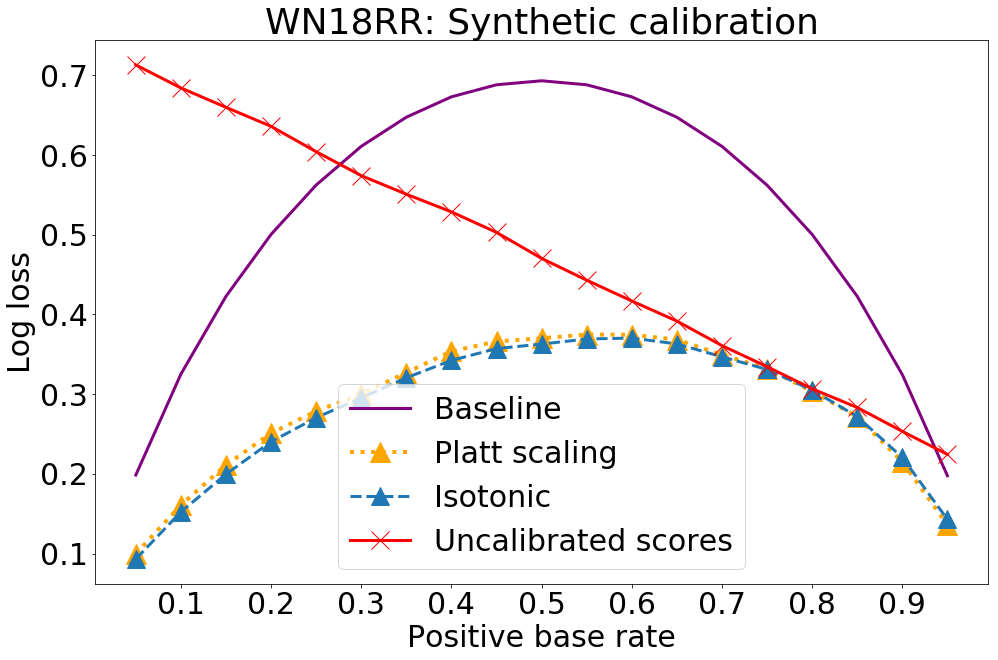

In [73]:
plt.figure(figsize=(16, 10))
plt.rcParams.update({'font.size': 30, 'axes.titlesize': 36})
plt.plot(ll.index, ll.baseline, "-", lw=3, label="Baseline",
         fillstyle='full', color='purple', markersize=18)
plt.plot(ll.index, ll.probas_pos, "^:",lw=4, label="Platt scaling",  
         fillstyle='full', color='orange', markersize=20)
plt.plot(ll.index, ll.probas_pos_iso, "^--",  lw=3, label="Isotonic", 
         fillstyle='full', color='tab:blue', markersize=18)
plt.plot(ll.index, ll.scores, "x-",lw=3,  
         fillstyle='full', color='r', markersize=18,
         label="Uncalibrated scores")

plt.xlabel("Positive base rate")
plt.ylabel("Log loss")
plt.legend()
plt.xticks(np.linspace(0.1, 0.9, 9))
plt.title("WN18RR: Synthetic calibration")